In [1]:
import sys
sys.path.append("../../code")

In [2]:
import gen_py3

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# Discriminator
# Full-convolution
class Discriminator(nn.Module):
    def __init__(self, img_dim=1, filter_num=64):
        super(Discriminator, self).__init__()

        self.img_mapper_layer = nn.Sequential(
            nn.Conv2d(img_dim, filter_num, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(filter_num),
            nn.ReLU(inplace=True),      # 1*28*28 -> 64*14*14
            nn.Conv2d(filter_num, filter_num*2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(filter_num*2),
            nn.ReLU(inplace=True),      # 64*14*14 -> 128*7*7
            nn.Conv2d(filter_num*2, filter_num*4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(filter_num*4),
            nn.ReLU(inplace=True),      # 128*7*7 -> 256*4*4
            nn.Conv2d(filter_num*4, 1, kernel_size=4, stride=1, padding=0)
            #nn.Sigmoid()           # 256*4*4 -> 1*1*1
        )
        #self.label_mapper_layer = nn.Linear(10, 1000)
        
        #self.fc_layer = nn.Sequential(
        #)
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x):
        x = self.img_mapper_layer(x)
        x = x.squeeze()
        return x

# Generator
# Full-convolution
class Generator(nn.Module):
    def __init__(self, v_dim=100, img_dim=1, filter_num=64):
        super(Generator, self).__init__()
        

        self.z_mapper_layer = nn.Sequential(
            nn.ConvTranspose2d(v_dim, filter_num*4, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(inplace=True), # 100*1*1 -> 256*4*4
            nn.ConvTranspose2d(filter_num*4, filter_num*2, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(inplace=True), # 256*4*4 -> 128*7*7
            nn.ConvTranspose2d(filter_num*2, filter_num, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(inplace=True), # 128*7*7 -> 64*13*13
            nn.ConvTranspose2d(filter_num, img_dim, kernel_size=4, stride=2, padding=0),  
            nn.Tanh()          # 64*13*13 -> 1*28*28
        )

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
        
    def forward(self, v):
        v = v.view(v.size(0), 100, 1, 1)
        v = self.z_mapper_layer(v)
        return v

class AutoEC(nn.Module):
    def __init__(self, v_dim=100, img_dim=1, filter_num=64):
        super(AutoEC, self).__init__()
        # img_mapper_layer
        self.img_mapper_layer = nn.Sequential(
            nn.Conv2d(img_dim, filter_num, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),      # 1*28*28 -> 64*14*14
            nn.Conv2d(filter_num, filter_num*2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),      # 64*14*14 -> 128*7*7
            nn.Conv2d(filter_num*2, filter_num*4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),      # 128*7*7 -> 256*4*4
        )
        
        # FC
        self.ec_fc_layer = nn.Sequential(
            nn.Linear(256*4*4, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,v_dim)
        )
        
        # z_mapper_layer
        self.v_mapper_layer = nn.Sequential(
            nn.ConvTranspose2d(v_dim, filter_num*4, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(inplace=True), # 100*1*1 -> 256*4*4
            nn.ConvTranspose2d(filter_num*4, filter_num*2, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(inplace=True), # 256*4*4 -> 128*7*7
            nn.ConvTranspose2d(filter_num*2, filter_num, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(inplace=True), # 128*7*7 -> 64*13*13
            nn.ConvTranspose2d(filter_num, img_dim, kernel_size=4, stride=2, padding=0),
            nn.Tanh()          # 64*13*13 -> 1*28*28
        )

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def Mapper(self, x):
        x = self.img_mapper_layer(x)
        x = x.view(x.size(0), 256*4*4)
        x = self.ec_fc_layer(x)
        return x

    def Decoder(self, v):
        v = v.view(v.size(0), 100, 1, 1)
        v = self.v_mapper_layer(v)
        return v
    
    def forward(self, x):
        x = self.Mapper(x)
        x = self.Decoder(x)
        return x

In [5]:
import random
class f_rand_mnist(nn.Module):
  def __init__(self):
    super(f_rand_mnist, self).__init__()
    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        nn.ReLU(inplace=True)
    )
    self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=0),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        nn.ReLU(inplace=True)
    )
    self.fc_layer_1 = nn.Sequential(
        nn.Linear(4*4*256, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.Dropout(0.5),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 10),
        nn.Sigmoid()
    )
    self.fc_layer_2 = nn.Sequential(
        nn.Linear(4*4*256, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.Dropout(0.5),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 10),
        nn.Sigmoid()
    )
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)
      
  def forward(self, x):
    i = [1,2]
    if random.choice(i) == 1:
      x = self.conv_layer_1(x)
    else:
      x = self.conv_layer_2(x)
    x = x.view(x.size(0), 4*4*256)
    if random.choice(i) == 1:
      x = self.fc_layer_1(x)
    else:
      x = self.fc_layer_2(x)
    return x

In [6]:
g_model = Generator()
d_model = Discriminator()
ec_model = AutoEC()
rand_model = torch.load('../../target/mnist/f_mnist.pkl')

In [7]:
config = 'THREAT_mnist.json'
data_set = 'mnist'

In [8]:
#threat_train(g_model, d_model, ec_model, rand_model, config, data_set)
gen_py3.threat_train(
    g_model,
    d_model,
    ec_model,
    rand_model,
    config,
    data_set
    )

epoch:0
d loss:-1.893373
g loss:12.295441
	g/d:2.216791
	g/img:8.566548
	g/adv:0.151210
ec loss:0.046487
cost:48.302411s
epoch:1
d loss:-1.377329
g loss:8.457915
	g/d:0.611977
	g/img:7.603238
	g/adv:0.024270
ec loss:0.019744
cost:49.090510s
epoch:2
d loss:-1.346690
g loss:7.112768
	g/d:-0.324900
	g/img:7.274991
	g/adv:0.016268
ec loss:0.013451
cost:49.311807s
epoch:3
d loss:-1.325478
g loss:6.871433
	g/d:-0.409082
	g/img:7.120522
	g/adv:0.015999
ec loss:0.010366
cost:49.453356s
epoch:4
d loss:-1.344989
g loss:6.763067
	g/d:-0.356896
	g/img:7.013791
	g/adv:0.010617
ec loss:0.008530
cost:49.606388s
epoch:5
d loss:-1.290306
g loss:6.416953
	g/d:-0.643532
	g/img:6.901782
	g/adv:0.015870
ec loss:0.007316
cost:49.739555s
epoch:6
d loss:-1.256067
g loss:5.996030
	g/d:-0.933310
	g/img:6.769197
	g/adv:0.016014
ec loss:0.006484
cost:49.589834s
epoch:7
d loss:-1.269119
g loss:5.810586
	g/d:-0.981306
	g/img:6.657063
	g/adv:0.013483
ec loss:0.005852
cost:49.445480s
epoch:8
d loss:-1.302621
g loss:5

In [10]:
import val

In [11]:
loss_file = [
    "../model/threat/mnist/g_loss.txt",
    "../model/threat/mnist/d_loss.txt"
    ]
file_type = "threat"

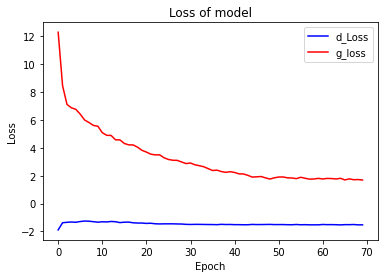

In [12]:
val.make_loss_curve(
    loss_file,
    file_type
)

In [13]:
g_path = "../model/threat/mnist/g_70.pth"
ec_path = "../model/threat/mnist/ec_70.pth"
choose = "test"

In [14]:
g_model.load_state_dict(torch.load(g_path))
ec_model.load_state_dict(torch.load(ec_path))

<All keys matched successfully>

In [15]:
gen_py3.threat_attack(
    g_model,
    ec_model,
    data_set,
    choose
    )

-test set start-
count:10000/10000,cost:0.005521s
test set cost:23.95731401s
saving...
-complete-


In [16]:
import tst

In [17]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc_layer = nn.Sequential(
            nn.Linear(28*28,1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 10),
            nn.Sigmoid()
    )
    def forward(self, x):
        x = x.view(x.size(0), 28*28)
        x = self.fc_layer(x)
        return x

In [18]:
t_model = FNN()

In [19]:
test_model="../../target/mnist/FNN.pt"
t_model.load_state_dict(torch.load(test_model))

<All keys matched successfully>

In [20]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape)
tst.robustness_test(
    model = t_model,
    adv_sample_path = '../sample/THREAT_mnist/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:81.780000%


In [21]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(256, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [22]:
t_model = LeNet()

In [23]:
test_model="../../target/mnist/LeNet.pt"
t_model.load_state_dict(torch.load(test_model))

<All keys matched successfully>

In [24]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape)
tst.robustness_test(
    model = t_model,
    adv_sample_path = '../sample/THREAT_mnist/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:77.770000%


In [25]:
import torch.nn.functional as F
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,kernel_size=3,padding=1,stride=stride,bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.right = nn.Sequential()
        
        if(inchannel != outchannel):
            self.right = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=3, padding=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel),
            )

    def forward(self, x):
        out = self.left(x)
        out += self.right(x)
        out =F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=1)
        self.conv2 = nn.Conv2d(128,128,3,stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=1)
        self.conv3 = nn.Conv2d(256, 256, 3, stride=2)
        #self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=1)
        self.conv4 = nn.Conv2d(256,256,6)
        self.fc = nn.Linear(256, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        layer = []
        for i in range(num_blocks):
            layer.append(block(self.inchannel,channels,stride))
            self.inchannel = channels
        #
        return nn.Sequential(*layer)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.conv2(out)
        out = self.layer3(out)
        out = self.conv3(out)
        #out = self.layer4(out)
        out = self.conv4(out)
        #out = F.avg_pool2d(out,4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock)


In [26]:
t_model = ResNet18()

In [27]:
test_model="../../target/mnist/ResNet18.pt"
t_model.load_state_dict(torch.load(test_model))

<All keys matched successfully>

In [28]:
tst.robustness_test(
    model = t_model,
    adv_sample_path = '../sample/THREAT_mnist/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:38.490000%
